In [55]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import sys
import scipy.io as sio
import scipy.stats as stats
import cv2

# 1. Convertimos los datos usando $\Delta_{ID}=1$

In [56]:
dir_path = 'masks/'
# add this path to the system path
sys.path.append(dir_path)

In [57]:
files = os.listdir(dir_path)

In [58]:
# create a dictionary of the masks
masks = {}

for file in files:
    name = file.split('_')[0]
    array = sio.loadmat(dir_path + file)['masks']
    n_steps = array.shape[-1]
    grid = np.zeros_like(array)
    grid[:, :, 0] = array[:, :, 0].copy()
    for i in range(1, n_steps):
        grid[:,:,i][grid[:,:,i-1]>=1] = 2
        grid[:,:,i][grid[:,:,i-1]==0] = array[:,:,i][grid[:,:,i-1]==0].copy()    
    masks[name] = grid.copy()


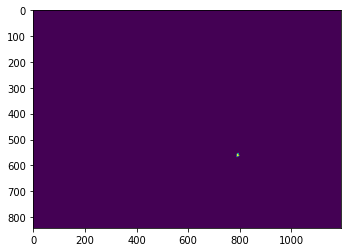

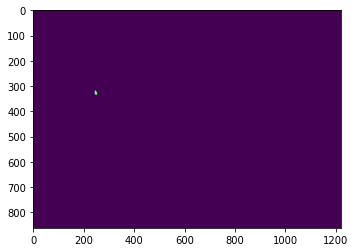

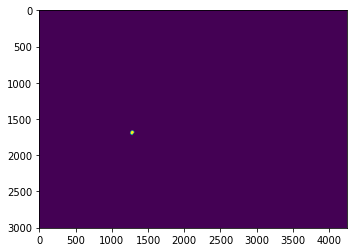

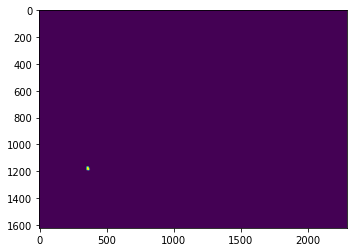

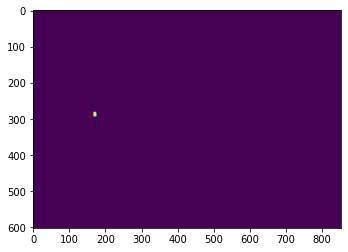

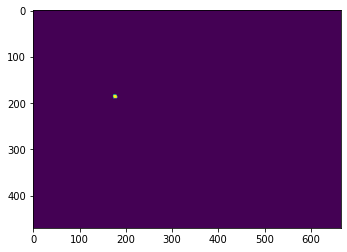

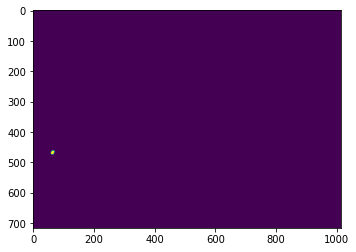

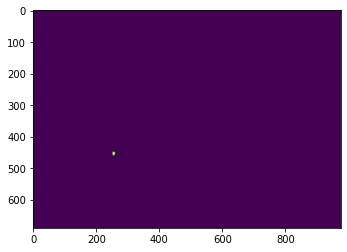

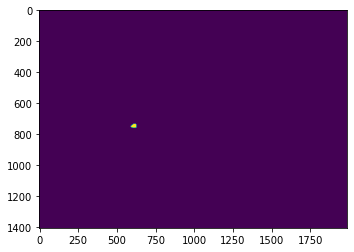

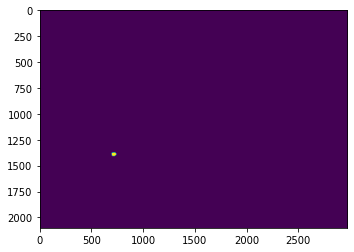

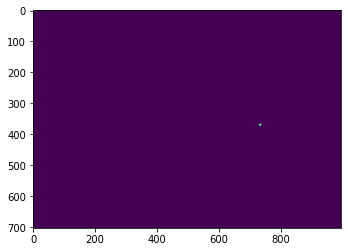

In [59]:
for name in masks.keys():
    
    plt.imshow(masks[name][:,:,0])
    plt.show()

# 2. Guardamos los datos en formato binario

In [60]:
import pickle
with open('grid_data_dict/masks.pkl', 'wb') as f:
    pickle.dump(masks, f)

In [61]:
masks = pickle.load(open('grid_data_dict/masks.pkl', 'rb'))

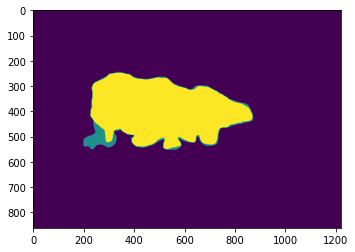

In [62]:
plt.imshow(masks['Beneixama'][:, :, -1])

# 3. Hacemos el CROP 

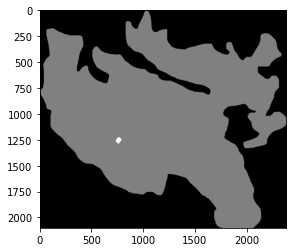

In [63]:
binary_mask = masks['Beniarda'][:, :, -1]
rows, cols = np.nonzero(binary_mask)
min_row, max_row = np.min(rows), np.max(rows)
min_col, max_col = np.min(cols), np.max(cols)
size_1, size_2 = max_row - min_row + 1, max_col - min_col + 1
size = np.max([size_1, size_2])
bbox = (min_row, min_col, max_row - min_row + 1, max_col - min_col + 1)
cropped_mask = binary_mask[min_row:max_row+1, min_col:max_col+1]
plt.imshow(cropped_mask, cmap='gray')
#plt.savefig('cropped_mask_Beniarda.png')
plt.show()

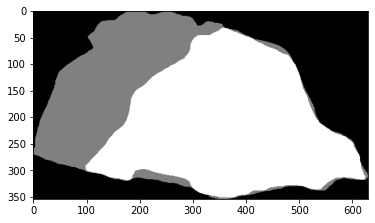

In [64]:
binary_mask = masks['Artana'][:, :, -1]
rows, cols = np.nonzero(binary_mask)
min_row, max_row = np.min(rows), np.max(rows)
min_col, max_col = np.min(cols), np.max(cols)
size_1, size_2 = max_row - min_row + 1, max_col - min_col + 1
size = np.max([size_1, size_2])
bbox = (min_row, min_col, max_row - min_row + 1, max_col - min_col + 1)
cropped_mask = binary_mask[min_row:max_row+1, min_col:max_col+1]
plt.imshow(cropped_mask, cmap='gray')
#plt.savefig('cropped_mask_Artana.png')
plt.show()

In [65]:
def get_bounding_square(mask):
    rows, cols = np.nonzero(mask)
    min_row, max_row = np.min(rows), np.max(rows)
    min_col, max_col = np.min(cols), np.max(cols)
    size_1, size_2 = max_row - min_row + 1, max_col - min_col + 1
    size = np.max([size_1, size_2])
    return size

sizes = [get_bounding_square(masks[name][:,:,-1]) for name in masks.keys()]
size = np.max(sizes)
if size%2 == 1:
    size += 1
size, sizes

(2378, [630, 672, 2377, 1442, 351, 248, 730, 387, 736, 1800, 607])

In [66]:
masks_cropped = {}
def pad_mask(mask, size):
    rows, cols = np.nonzero(mask)
    min_row, max_row = np.min(rows), np.max(rows)
    min_col, max_col = np.min(cols), np.max(cols)
    size_1, size_2 = max_row - min_row + 1, max_col - min_col + 1
    row_padding = (size - size_1) // 2
    col_padding = (size - size_2) // 2
    padded_mask = np.zeros((size, size))
    padded_mask[row_padding:row_padding + size_1, col_padding:col_padding + size_2] = mask[min_row:max_row + 1, min_col:max_col + 1]
    return padded_mask

for name in masks.keys():
    z = masks[name].shape[-1]
    aux = np.zeros(shape=(size, size, z))
    for i in range(masks[name].shape[-1]):
        binary_mask = masks[name][:, :, i]
        padded_mask = pad_mask(binary_mask, size)
        aux[:,:, i] = padded_mask.copy()
    masks_cropped[name] = aux.copy()
    #binary_mask = masks[name][:, :, -1]
    #padded_mask = pad_mask(binary_mask, size)
    #plt.imshow(padded_mask, cmap='gray')
    #aux[name] = padded_mask.copy()

Artana
(2378, 2378, 4) (2379, 2379, 4)


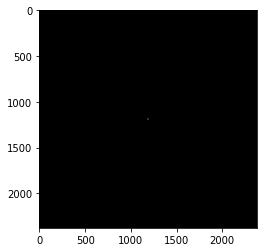

Beneixama
(2378, 2378, 9) (2379, 2379, 9)


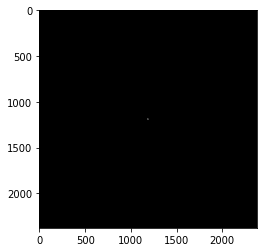

Beniarda
(2378, 2378, 2) (2379, 2379, 2)


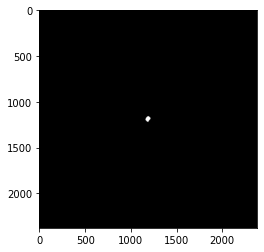

Bolulla
(2378, 2378, 9) (2379, 2379, 9)


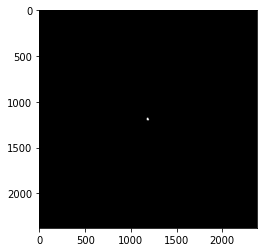

Carcaixent
(2378, 2378, 6) (2379, 2379, 6)


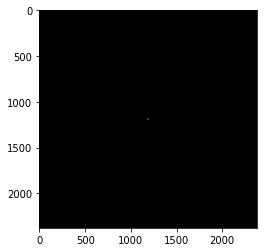

Chella
(2378, 2378, 7) (2379, 2379, 7)


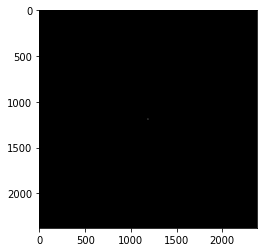

Gatova
(2378, 2378, 11) (2379, 2379, 11)


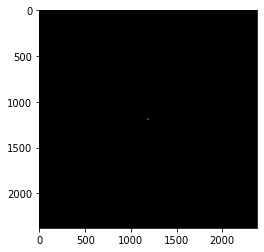

Llutxent
(2378, 2378, 7) (2379, 2379, 7)


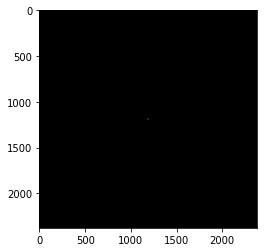

Montan
(2378, 2378, 4) (2379, 2379, 4)


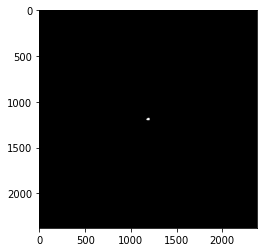

ValldEbo
(2378, 2378, 6) (2379, 2379, 6)


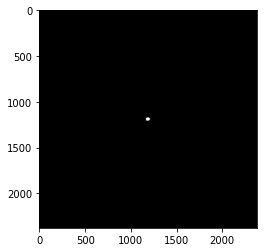

VallGallinera
(2378, 2378, 4) (2379, 2379, 4)


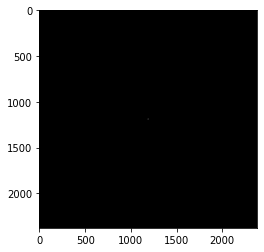

In [67]:
for name in masks_cropped.keys():
    print(name)
    shape = masks_cropped[name].shape[0] + 1, masks_cropped[name].shape[1] + 1, masks_cropped[name].shape[2]
    print(masks_cropped[name].shape, shape)
    #print(np.where(masks_cropped[name][:,:,0] == 2))
    test = np.zeros(shape=shape)
    test[1:, 1:, :] = masks_cropped[name][:,:,:]
    try:
        plt.imshow(test[:, :, 0], cmap='gray')
        plt.show()
    except:
        pass

In [68]:
masks_crop_resize = {}
resize = 256
for name in masks_cropped.keys():
    z = masks_cropped[name].shape[-1]
    aux = np.zeros(shape=(resize, resize, z))
    for i in range(masks_cropped[name].shape[-1]):
        binary_mask = masks_cropped[name][:, :, i]
        aux[:,:, i] = cv2.resize(binary_mask, (resize, resize), interpolation=cv2.INTER_NEAREST)
    masks_crop_resize[name] = aux.copy()

Artana (256, 256, 4)
(array([128], dtype=int64), array([128], dtype=int64))
(array([123, 123, 123, 123, 124, 124, 124, 124, 124, 124, 124, 124, 125,
       125, 125, 125, 125, 125, 125, 125, 125, 126, 126, 126, 126, 126,
       126, 126, 126, 126, 126, 126, 126, 127, 127, 127, 127, 127, 127,
       127, 127, 127, 127, 127, 127, 127, 128, 128, 128, 128, 128, 128,
       128, 128, 128, 128, 128, 128, 128, 129, 129, 129, 129, 129, 129,
       129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 130, 130, 130,
       130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130,
       130, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131,
       131, 131, 131, 131, 131, 132, 132, 132, 132, 132, 132, 132, 132,
       132, 132, 132, 132, 133, 133], dtype=int64), array([125, 126, 127, 128, 123, 124, 125, 126, 127, 128, 129, 130, 123,
       124, 125, 126, 127, 128, 129, 130, 131, 123, 124, 125, 126, 127,
       128, 129, 130, 131, 132, 133, 134, 122, 123, 124, 125, 126, 127,
       

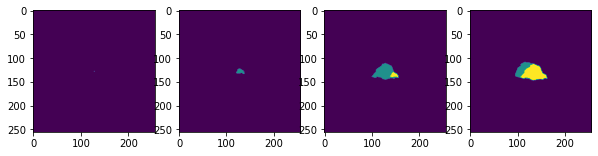

Beneixama (256, 256, 9)
(array([128], dtype=int64), array([128], dtype=int64))
(array([120, 120, 120, 120, 120, 121, 121, 121, 121, 121, 121, 121, 122,
       122, 122, 122, 122, 122, 122, 122, 122, 123, 123, 123, 123, 123,
       123, 123, 123, 123, 123, 123, 123, 124, 124, 124, 124, 124, 124,
       124, 124, 124, 124, 124, 124, 124, 125, 125, 125, 125, 125, 125,
       125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 126, 126,
       126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126,
       127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127,
       127, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128,
       128, 128, 128, 128, 129, 129, 129, 129, 129, 129, 129, 129, 129,
       129, 129, 129, 129, 129, 129, 129, 129, 130, 130, 130, 130, 130,
       130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 131, 131,
       131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131,
       132, 132, 132, 132, 132, 132, 132, 132, 132, 132,

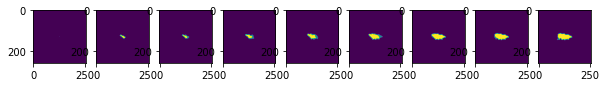

Beniarda (256, 256, 2)
(array([125, 125, 126, 126, 126, 126, 127, 127, 127, 127, 127, 128, 128,
       128, 128, 128, 129, 129, 129, 129, 130, 130, 130, 131, 131],
      dtype=int64), array([128, 129, 127, 128, 129, 130, 126, 127, 128, 129, 130, 126, 127,
       128, 129, 130, 126, 127, 128, 129, 126, 127, 128, 127, 128],
      dtype=int64))
(array([ 15,  16,  16, ..., 241, 241, 241], dtype=int64), array([111, 109, 110, ..., 218, 219, 220], dtype=int64))


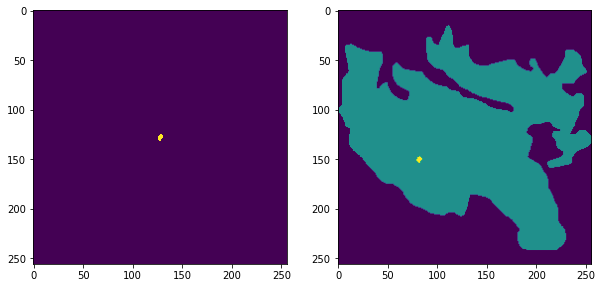

Bolulla (256, 256, 9)
(array([127, 127, 128, 128, 129, 129, 129], dtype=int64), array([127, 128, 127, 128, 127, 128, 129], dtype=int64))
(array([117, 117, 117, 118, 118, 118, 118, 119, 119, 119, 119, 120, 120,
       120, 120, 121, 121, 121, 122, 122, 122, 122, 123, 123, 123, 123,
       124, 124, 124, 124, 125, 125, 125, 125, 125, 125, 126, 126, 126,
       126, 126, 126, 127, 127, 127, 127, 127, 127, 128, 128, 128, 128,
       128, 128, 129, 129, 129, 129, 129, 130, 130, 130, 130, 130, 131,
       131, 131, 131, 131, 132, 132, 132, 132, 132, 133, 133, 133, 133,
       133, 133, 133, 134, 134, 134, 134, 134, 134, 134, 135, 135, 135,
       135, 135, 135, 136, 136, 136, 136, 136, 137, 137, 137, 138, 139],
      dtype=int64), array([122, 123, 124, 122, 123, 124, 125, 122, 123, 124, 125, 122, 123,
       124, 125, 123, 124, 125, 123, 124, 125, 126, 123, 124, 125, 126,
       123, 124, 125, 126, 121, 122, 123, 124, 125, 126, 121, 122, 123,
       124, 125, 126, 121, 122, 123, 124, 125, 12

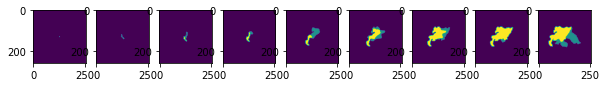

Carcaixent (256, 256, 6)
(array([128], dtype=int64), array([128], dtype=int64))
(array([127, 127], dtype=int64), array([128, 129], dtype=int64))
(array([126, 126, 126, 126, 126, 126, 126, 126, 127, 127, 127, 127, 127,
       127, 127, 127, 127, 127, 127, 127, 127, 127, 128, 128, 128, 128,
       128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 129, 129, 129,
       129, 129, 129, 129, 129, 130, 130], dtype=int64), array([129, 130, 131, 132, 133, 134, 135, 136, 120, 123, 124, 125, 126,
       127, 128, 129, 130, 131, 132, 133, 134, 135, 121, 122, 123, 124,
       125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 125, 126, 127,
       130, 131, 132, 133, 134, 132, 133], dtype=int64))
(array([124, 124, 124, 124, 124, 124, 124, 125, 125, 125, 125, 126, 126,
       126, 126, 126, 126, 126, 127, 127, 127, 127, 127, 127, 127, 127,
       127, 127, 127, 127, 128, 128, 128, 128, 128, 128, 128, 128, 128,
       128, 128, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 130,
       130, 130, 13

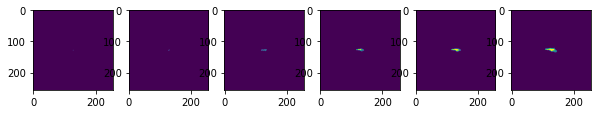

Chella (256, 256, 7)
(array([128], dtype=int64), array([128], dtype=int64))
(array([128, 128, 128, 129], dtype=int64), array([127, 128, 129, 129], dtype=int64))
(array([125, 126, 126, 126, 126, 127, 127, 127, 128, 128, 128, 128, 128,
       129, 129, 129, 129, 129, 129, 129, 130, 130, 130, 130, 130, 130,
       131], dtype=int64), array([128, 126, 127, 128, 129, 128, 129, 130, 126, 127, 128, 129, 130,
       126, 127, 128, 129, 130, 131, 132, 127, 128, 129, 130, 131, 132,
       132], dtype=int64))
(array([126, 127, 127, 128, 128, 128, 128, 128, 128, 128, 128, 129, 129,
       129, 129, 129, 129, 129, 129, 129, 130, 130, 130, 130, 130, 130,
       130, 130, 130, 130, 130, 131, 131, 131, 131, 131, 131, 131, 131,
       131, 132, 132, 132, 132, 132, 132, 132, 132, 133, 133, 133, 133,
       133, 133, 133, 134, 134], dtype=int64), array([118, 119, 120, 119, 120, 121, 122, 123, 124, 125, 126, 121, 122,
       123, 124, 125, 126, 127, 128, 129, 124, 125, 126, 127, 128, 129,
       130, 131,

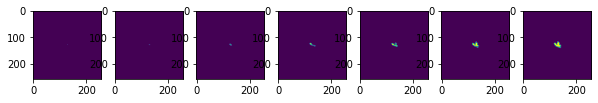

Gatova (256, 256, 11)
(array([128], dtype=int64), array([128], dtype=int64))
(array([126, 126, 126, 126, 126, 126, 126, 127, 127, 127, 127, 127, 127,
       127, 127, 128, 128, 128, 128, 128, 128, 129, 129, 129, 129, 129,
       129, 129, 129, 129, 130, 130, 130, 130, 130, 130, 130, 130],
      dtype=int64), array([127, 128, 129, 130, 131, 132, 133, 125, 126, 127, 128, 129, 132,
       133, 134, 124, 125, 126, 127, 128, 129, 122, 123, 124, 125, 126,
       127, 128, 129, 130, 122, 123, 124, 125, 126, 127, 128, 129],
      dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([121, 121, 121, 121, 122, 122, 122, 122, 122, 122, 122, 122, 122,
       122, 122, 122, 122, 122, 122, 122, 122, 122, 123, 123, 123, 123,
       123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123,
       123, 123, 123, 123, 123, 123, 123, 124, 124, 124, 124, 124, 124,
       124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124,
       124, 124, 124, 124, 124, 124, 124, 125, 1

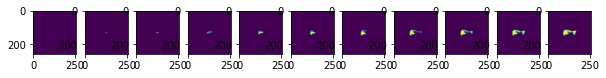

Llutxent (256, 256, 7)
(array([128], dtype=int64), array([128], dtype=int64))
(array([124, 125, 126, 126, 126, 127, 127, 127, 128, 128, 129, 129, 129,
       129, 130, 130, 130, 131, 131], dtype=int64), array([129, 129, 127, 128, 129, 127, 128, 129, 127, 128, 126, 127, 128,
       129, 126, 127, 128, 126, 127], dtype=int64))
(array([122, 123, 123, 124, 124, 125, 125, 126, 126, 126, 127, 127, 127,
       127, 127, 128, 128, 128, 128, 128, 128, 129, 129, 129, 129, 129,
       129, 130, 130, 130, 130, 130, 130, 130, 131, 131, 131, 131, 131,
       131, 131, 132, 132, 132, 132, 132, 132, 133], dtype=int64), array([128, 127, 128, 127, 128, 127, 128, 126, 127, 128, 125, 126, 127,
       128, 133, 124, 125, 126, 127, 128, 133, 124, 125, 126, 127, 128,
       129, 124, 125, 126, 127, 128, 129, 132, 123, 124, 125, 126, 127,
       128, 129, 124, 125, 126, 127, 128, 129, 129], dtype=int64))
(array([116, 117, 117, 117, 118, 118, 118, 118, 118, 119, 119, 119, 119,
       119, 119, 119, 120, 120, 1

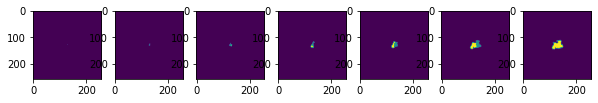

Montan (256, 256, 4)
(array([127, 127, 128, 128, 128, 129, 129, 129], dtype=int64), array([128, 129, 127, 128, 129, 127, 128, 129], dtype=int64))
(array([106, 107, 107, 108, 108, 108, 109, 109, 109, 110, 110, 110, 110,
       111, 111, 111, 111, 112, 112, 112, 112, 112, 113, 113, 113, 113,
       113, 113, 113, 114, 114, 114, 114, 114, 114, 114, 114, 114, 115,
       115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 116,
       116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116,
       117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117,
       117, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 119,
       119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 120, 120, 120,
       120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 121,
       121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121,
       121, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122,
       122, 122, 122, 122, 123, 123, 123, 123, 123, 123, 123,

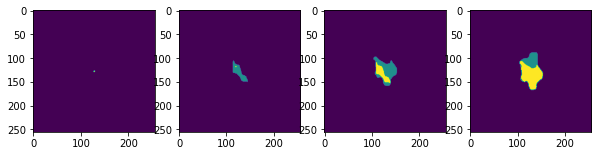

ValldEbo (256, 256, 6)
(array([127, 127, 127, 127, 128, 128, 128, 128, 128, 129, 129, 129, 129],
      dtype=int64), array([126, 127, 128, 129, 126, 127, 128, 129, 130, 126, 127, 128, 129],
      dtype=int64))
(array([102, 102, 102, ..., 154, 154, 154], dtype=int64), array([135, 136, 137, ..., 111, 112, 113], dtype=int64))
(array([ 87,  87,  87, ..., 164, 169, 169], dtype=int64), array([120, 121, 122, ...,  75,  75,  76], dtype=int64))
(array([ 83,  83,  83, ..., 173, 173, 173], dtype=int64), array([119, 120, 121, ...,  79,  80,  81], dtype=int64))
(array([ 72,  72,  72, ..., 184, 184, 184], dtype=int64), array([115, 116, 117, ..., 177, 178, 179], dtype=int64))
(array([ 68,  68,  68, ..., 187, 187, 187], dtype=int64), array([114, 115, 116, ..., 178, 179, 180], dtype=int64))


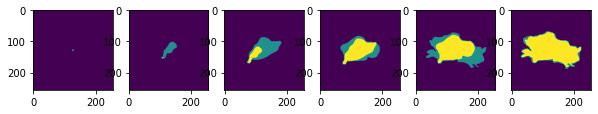

VallGallinera (256, 256, 4)
(array([128], dtype=int64), array([128], dtype=int64))
(array([126, 126, 126, 127, 127, 127, 127, 128, 128, 128, 128, 128, 128,
       128, 128, 128, 128, 128, 129, 129, 129, 129, 129, 129, 129, 129,
       129, 130, 130, 130, 130], dtype=int64), array([131, 132, 133, 130, 131, 132, 133, 122, 123, 124, 125, 126, 127,
       128, 129, 130, 131, 132, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 126, 127, 128, 129], dtype=int64))
(array([117, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118,
       118, 118, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119,
       119, 119, 119, 119, 119, 119, 119, 120, 120, 120, 120, 120, 120,
       120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120,
       120, 120, 120, 120, 120, 120, 120, 120, 121, 121, 121, 121, 121,
       121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121,
       121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121,
       121, 121, 122, 122, 12

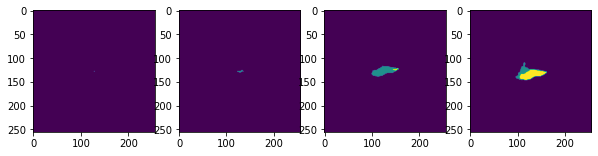

In [69]:
for name in masks_crop_resize.keys():
    print(name, masks_crop_resize[name].shape)
    fig, ax = plt.subplots(1, masks_crop_resize[name].shape[-1], figsize=(10, 5))
    for i in range(masks_crop_resize[name].shape[-1]):
        binary_mask = masks_crop_resize[name][:, :, i]
        ax[i].imshow(binary_mask)
        print(np.where(binary_mask == 1))
    plt.show()

In [70]:
for name in masks_crop_resize.keys():
    if np.sum(masks_crop_resize[name][:,:,0]) == 0:
        print(name)

In [71]:
for name in masks_crop_resize.keys():
    print(name, np.where(masks_crop_resize[name][:,:,0] == 1))

Artana (array([128], dtype=int64), array([128], dtype=int64))
Beneixama (array([128], dtype=int64), array([128], dtype=int64))
Beniarda (array([125, 125, 126, 126, 126, 126, 127, 127, 127, 127, 127, 128, 128,
       128, 128, 128, 129, 129, 129, 129, 130, 130, 130, 131, 131],
      dtype=int64), array([128, 129, 127, 128, 129, 130, 126, 127, 128, 129, 130, 126, 127,
       128, 129, 130, 126, 127, 128, 129, 126, 127, 128, 127, 128],
      dtype=int64))
Bolulla (array([127, 127, 128, 128, 129, 129, 129], dtype=int64), array([127, 128, 127, 128, 127, 128, 129], dtype=int64))
Carcaixent (array([128], dtype=int64), array([128], dtype=int64))
Chella (array([128], dtype=int64), array([128], dtype=int64))
Gatova (array([128], dtype=int64), array([128], dtype=int64))
Llutxent (array([128], dtype=int64), array([128], dtype=int64))
Montan (array([127, 127, 128, 128, 128, 129, 129, 129], dtype=int64), array([128, 129, 127, 128, 129, 127, 128, 129], dtype=int64))
ValldEbo (array([127, 127, 127, 12

Artana
(256, 256, 4) (257, 257, 4)


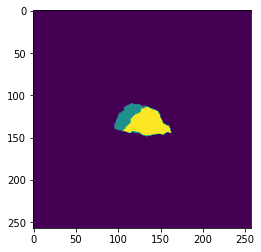

Beneixama
(256, 256, 9) (257, 257, 9)


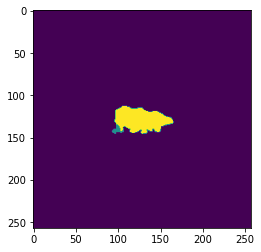

Beniarda
(256, 256, 2) (257, 257, 2)


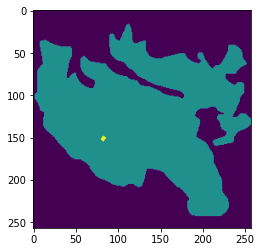

Bolulla
(256, 256, 9) (257, 257, 9)


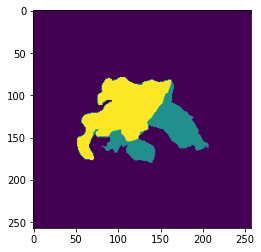

Carcaixent
(256, 256, 6) (257, 257, 6)


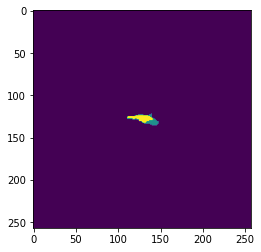

Chella
(256, 256, 7) (257, 257, 7)


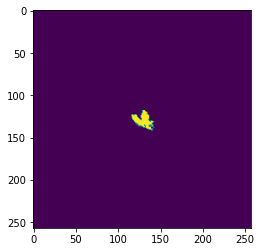

Gatova
(256, 256, 11) (257, 257, 11)


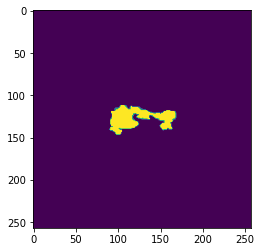

Llutxent
(256, 256, 7) (257, 257, 7)


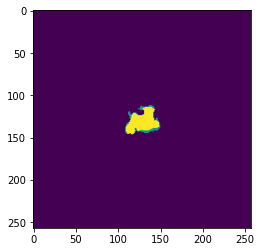

Montan
(256, 256, 4) (257, 257, 4)


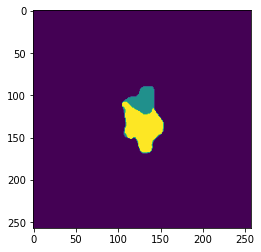

ValldEbo
(256, 256, 6) (257, 257, 6)


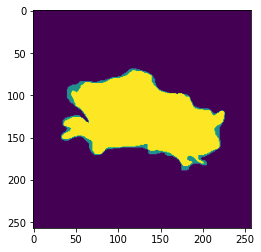

VallGallinera
(256, 256, 4) (257, 257, 4)


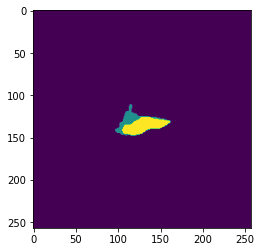

In [72]:
for name in masks_crop_resize.keys():
    print(name)
    shape = masks_crop_resize[name].shape[0] + 1, masks_crop_resize[name].shape[1] + 1, masks_crop_resize[name].shape[2]
    print(masks_crop_resize[name].shape, shape)
    test = np.zeros(shape=shape)
    test[1:, 1:, :] = masks_crop_resize[name][:,:,:]
    masks_crop_resize[name] = test.copy()
    plt.imshow(test[:, :, -1])
    plt.show()

In [73]:
with open('grid_data_dict/masks_scaled.pkl', 'wb') as f:
    pickle.dump(masks_crop_resize, f)

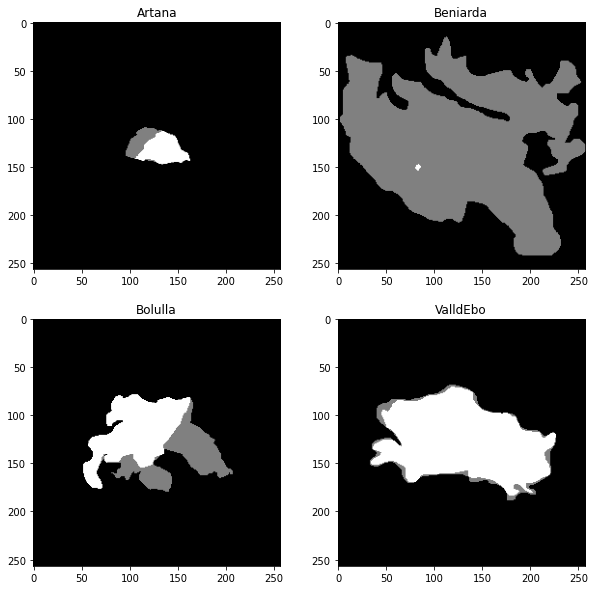

In [74]:
# Lista con los nombres que deseas visualizar
names_to_show = ["Artana", "Beniarda", "Bolulla", "ValldEbo"]

# Crear una figura con subplots divididos en 4 filas y 2 columnas
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Recorrer los subplots y agregar la imagen correspondiente
for i, ax in enumerate(axs.ravel()):
    if i < len(names_to_show):
        name = names_to_show[i]
        ax.imshow(masks_crop_resize[name][:, :, -1], cmap='gray')
        ax.set_title(name)

# Mostrar la figura
plt.savefig('Figures/masks_crop_resize.png')
plt.show()


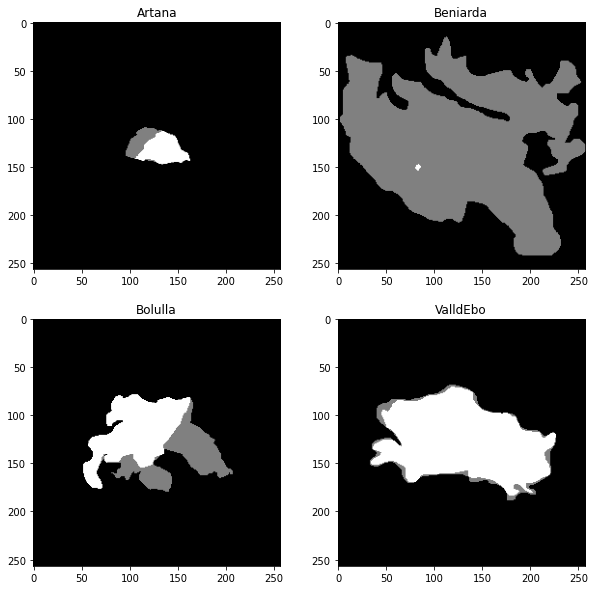

In [75]:
fig

In [76]:
with open('grid_data_dict/masks_scaled.pkl', 'wb') as f:
    pickle.dump(masks_crop_resize, f)

# 4. Guardamos todo en un dict

In [77]:
dict_data_final = {}
path = 'C:\\Users\\joanb\\Desktop\\data_incendios\\FINAL_DATA\\dataframes\\'
path_nps = 'C:\\Users\\joanb\\Desktop\\data_incendios\\FINAL_DATA\\masks\\'
for file in os.listdir(path):
    name = file.split('_')[1]
    df = pd.read_csv(path + file, sep=';', index_col=0)
    binary_mask = masks_crop_resize[name]
    np.save(path_nps + 'grid_' + name + '.npy', binary_mask)
    dict_data_final[name] = (df, binary_mask)

with open('grid_data_dict/dict_data_final.pkl', 'wb') as f:
    pickle.dump(dict_data_final, f)


Artana
                     Temperatura  Humedad       Rho     Theta
Fecha                                                        
2016-07-25 15:00:00        28.81    44.63  0.908365  2.652900
2016-07-25 15:30:00        27.61    49.51  0.894910  2.474877
2016-07-25 16:00:00        27.30    53.80  0.814218  2.537709
2016-07-25 16:30:00        27.42    52.78  0.794672  2.448697
2016-07-25 17:00:00        27.51    50.66  0.758823  2.431244
...                          ...      ...       ...       ...
2016-07-27 10:00:00        27.81    62.03  0.656967  2.405064
2016-07-27 10:30:00        27.01    67.93  0.648663  2.012365
2016-07-27 11:00:00        27.86    65.52  0.790158  2.183407
2016-07-27 11:30:00        27.21    67.24  0.783200  2.638938
2016-07-27 12:00:00        27.10    68.17  0.827459  2.565634

[91 rows x 4 columns]


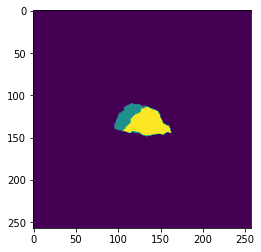

Beneixama
                     Temperatura    Humedad       Rho     Theta
Fecha                                                          
2019-07-15 14:00:00    34.000000  27.000000  0.992820  4.712389
2019-07-15 14:30:00    33.804940  26.988157  0.994792  5.515899
2019-07-15 15:00:00    34.549110  26.998247  0.998886  5.080164
2019-07-15 15:30:00    34.798327  25.995983  0.947882  5.490297
2019-07-15 16:00:00    35.567543  22.469045  0.958420  4.996098
2019-07-15 16:30:00    35.440671  19.694720  0.999076  4.689727
2019-07-15 17:00:00    35.486595  18.318667  0.982733  5.112138
2019-07-15 17:30:00    35.348831  17.417553  0.963659  5.203085
2019-07-15 18:00:00    35.578373  15.901377  0.983772  4.683797
2019-07-15 18:30:00    34.753903  27.698387  0.948130  6.984050
2019-07-15 19:00:00    33.033794  37.207983  0.972815  0.375628
2019-07-15 19:30:00    32.179913  39.825633  0.995339  0.650459
2019-07-15 20:00:00    30.871639  45.310223  0.990229  0.793670
2019-07-15 20:30:00    29.8757

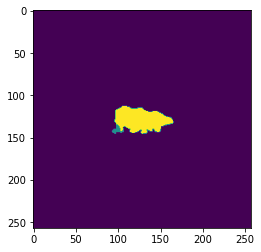

Beniarda
                     Temperatura  Humedad       Rho     Theta
Fecha                                                        
2020-08-28 21:00:00         26.0     59.0  0.647898  3.612832
2020-08-28 21:30:00         26.2     55.0  0.293862  3.508112
2020-08-28 22:00:00         25.8     53.0  0.501369  3.612832
2020-08-28 22:30:00         26.2     52.0  0.000000  3.455752
2020-08-28 23:00:00         25.8     52.0  0.293862  4.276057
2020-08-28 23:30:00         24.7     56.0  0.501369  3.612832
2020-08-29 00:00:00         25.3     51.0  0.000000  4.276057
2020-08-29 00:30:00         25.2     47.0  0.293862  4.310963
2020-08-29 01:00:00         25.1     47.0  0.293862  2.548181
2020-08-29 01:30:00         24.9     47.0  0.751367  4.450590
2020-08-29 02:00:00         24.7     46.0  0.293862  4.607669
2020-08-29 02:30:00         24.3     44.0  0.501369  3.333579
2020-08-29 03:00:00         24.0     41.0  0.647898  3.403392
2020-08-29 03:30:00         23.6     38.0  0.914339  4.433136

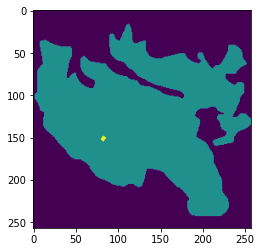

Bolulla
                     Temperatura    Humedad       Rho     Theta
Fecha                                                          
2016-09-05 14:00:00    35.720000  20.390000  0.515268  3.815290
2016-09-05 14:30:00    35.040000  21.620000  0.476934  3.806563
2016-09-05 15:00:00    34.380000  21.380000  0.460764  3.825762
2016-09-05 15:30:00    35.070000  19.950000  0.433107  3.820526
2016-09-05 16:00:00    35.550000  19.810000  0.367991  3.961897
2016-09-05 16:30:00    35.420000  19.270000  0.309052  3.820526
2016-09-05 17:00:00    35.290000  19.090000  0.204145  4.005531
2016-09-05 17:30:00    34.880000  18.430000  0.172375  4.288274
2016-09-05 18:00:00    33.510000  21.650000  0.054972  4.960226
2016-09-05 18:30:00    31.300000  25.730000  0.002172  5.359906
2016-09-05 19:00:00    29.830000  27.320000  0.104978  0.722043
2016-09-05 19:30:00    29.350000  26.940000  0.152338  5.565855
2016-09-05 20:00:00    29.470000  25.940000  0.193693  0.186227
2016-09-05 20:30:00    29.310000

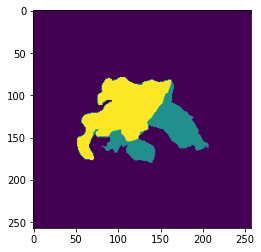

Carcaixent
                     Temperatura    Humedad       Rho     Theta
Fecha                                                          
2016-06-16 17:00:00    23.753846  27.000000  0.577330  4.398230
2016-06-16 17:30:00    23.753846  28.488864  0.482162  4.360725
2016-06-16 18:00:00    23.753846  29.000000  0.638589  4.415683
2016-06-16 18:30:00    23.753846  29.261136  0.766756  4.496821
2016-06-16 19:00:00    23.753846  30.000000  0.774055  4.537856
...                          ...        ...       ...       ...
2016-06-18 07:00:00    19.900000  81.000000  0.075302  0.017453
2016-06-18 07:30:00    20.693416  79.202636  0.203482 -0.113768
2016-06-18 08:00:00    21.400000  68.000000  0.374826  0.785398
2016-06-18 08:30:00    22.231584  56.797364  0.528148  1.588571
2016-06-18 09:00:00    23.400000  55.000000  0.638589  1.169371

[81 rows x 4 columns]


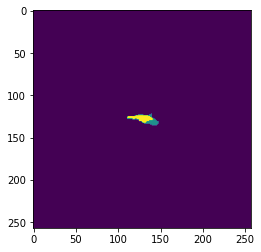

Chella
                     Temperatura  Humedad       Rho     Theta
Fecha                                                        
2016-06-15 20:00:00        26.10    23.26  0.791523  4.977679
2016-06-15 20:30:00        25.63    24.15  0.801694  4.972443
2016-06-15 21:00:00        25.03    26.54  0.800829  4.974188
2016-06-15 21:30:00        24.36    29.01  0.804690  4.965462
2016-06-15 22:00:00        24.05    29.21  0.755124  4.918338
...                          ...      ...       ...       ...
2016-06-17 07:00:00        20.10    46.39  0.615898  3.902556
2016-06-17 07:30:00        21.41    42.96  0.608307  3.900811
2016-06-17 08:00:00        22.96    37.93  0.544894  4.579744
2016-06-17 08:30:00        23.61    36.24  0.533876  3.420845
2016-06-17 09:00:00        24.22    34.58  0.447709  2.713987

[75 rows x 4 columns]


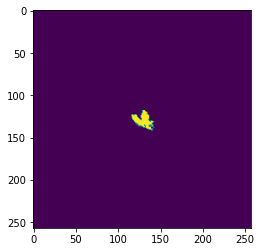

Gatova
                     Temperatura  Humedad       Rho     Theta
Fecha                                                        
2017-06-28 19:00:00        27.80    27.82  0.720387  4.977679
2017-06-28 19:30:00        26.83    30.08  0.635431  4.639085
2017-06-28 20:00:00        26.51    30.40  0.756716  4.817109
2017-06-28 20:30:00        26.47    30.47  0.671567  4.769985
2017-06-28 21:00:00        25.94    32.13  0.396205  5.188864
...                          ...      ...       ...       ...
2017-06-30 15:00:00        22.94    41.18  0.870513  2.076942
2017-06-30 15:30:00        22.12    46.03  0.847905  1.891937
2017-06-30 16:00:00        21.46    51.07  0.797334  2.047271
2017-06-30 16:30:00        21.36    53.50  0.707957  2.157227
2017-06-30 17:00:00        21.35    54.27  0.648663  2.249729

[93 rows x 4 columns]


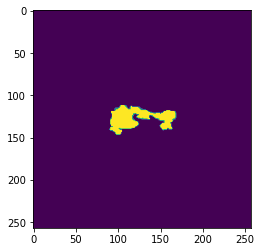

Llutxent
                     Temperatura    Humedad       Rho     Theta
Fecha                                                          
2018-08-06 14:30:00    37.200000  35.000000  0.993332  2.356194
2018-08-06 15:00:00    36.815838  32.365296  0.970567  3.372475
2018-08-06 15:30:00    36.896037  31.015054  0.913182  4.005388
2018-08-06 16:00:00    37.129319  30.651821  0.815513  4.349611
2018-08-06 16:30:00    37.204404  30.978141  0.695555  4.499821
...                          ...        ...       ...       ...
2018-08-08 18:00:00    27.074712  72.088916  0.629636  4.125879
2018-08-08 18:30:00    26.972981  72.564731  0.461690  1.952488
2018-08-08 19:00:00    27.408154  72.003077  0.466723  0.564880
2018-08-08 19:30:00    27.557929  74.212114  0.553775  1.244026
2018-08-08 20:00:00    26.600000  83.000000  0.609158  5.270894

[108 rows x 4 columns]


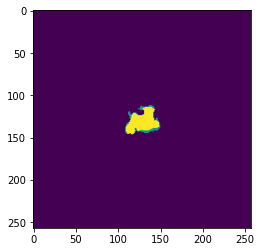

Montan
                     Temperatura    Humedad       Rho     Theta
Fecha                                                          
2015-07-07 20:30:00    22.400000  66.000000  0.075302  4.380776
2015-07-07 21:00:00    22.045341  63.112328  0.060470  4.131891
2015-07-07 21:30:00    21.607547  62.986146  0.143286  4.152223
2015-07-07 22:00:00    21.144214  64.356412  0.234799  4.278259
2015-07-07 22:30:00    20.712937  65.958081  0.269314  4.346487
...                          ...        ...       ...       ...
2015-07-10 08:00:00    23.734333  68.808879  0.212251  1.109228
2015-07-10 08:30:00    24.773734  64.384149  0.308797  1.285078
2015-07-10 09:00:00    25.713952  61.971090  0.423946  1.362885
2015-07-10 09:30:00    26.430776  60.524705  0.555689  1.538339
2015-07-10 10:00:00    26.800000  59.000000  0.690969  2.007129

[124 rows x 4 columns]


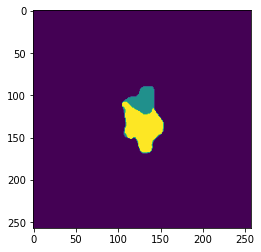

ValldEbo
                     Temperatura  Humedad       Rho     Theta
Fecha                                                        
2015-05-14 10:30:00        37.28     9.59  0.755656  2.302089
2015-05-14 11:00:00        38.05     9.15  0.659198  3.267256
2015-05-14 11:30:00        38.27     9.44  0.717330  3.080506
2015-05-14 12:00:00        38.42     8.59  0.736332  4.152138
2015-05-14 12:30:00        38.39     8.74  0.680722  2.644174
...                          ...      ...       ...       ...
2015-05-15 15:00:00        26.43    19.26  0.834443  4.892158
2015-05-15 15:30:00        26.19    18.86  0.788785  4.871214
2015-05-15 16:00:00        26.72    19.64  0.783200  4.825835
2015-05-15 16:30:00        26.54    23.14  0.639374  5.190609
2015-05-15 17:00:00        25.37    26.84  0.540918  3.940953

[62 rows x 4 columns]


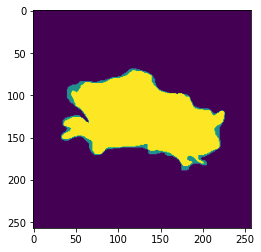

VallGallinera
                     Temperatura  Humedad       Rho     Theta
Fecha                                                        
2020-08-08 16:30:00         38.3     20.0  0.745901  1.797689
2020-08-08 17:00:00         38.6     17.0  0.781781  1.727876
2020-08-08 17:30:00         38.6     17.0  0.828208  1.815142
2020-08-08 18:00:00         38.5     17.0  0.812595  1.832596
2020-08-08 18:30:00         38.6     17.0  0.704122  2.076942
...                          ...      ...       ...       ...
2020-08-10 18:00:00         35.1     28.0  0.849222  1.797689
2020-08-10 18:30:00         34.6     27.0  0.767070  2.111848
2020-08-10 19:00:00         33.4     28.0  0.756716  1.692969
2020-08-10 19:30:00         32.6     29.0  0.761949  1.658063
2020-08-10 20:00:00         31.8     30.0  0.751367  1.797689

[104 rows x 4 columns]


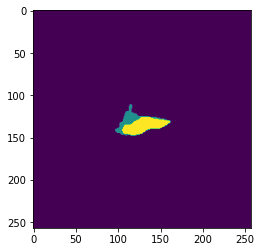

In [78]:
for name in dict_data_final.keys():
    print(name)
    print(dict_data_final[name][0])
    plt.imshow(dict_data_final[name][1][:, :, -1])
    plt.show()